# PAGA and sub-cluster 

In [1]:
import scanpy as sc
import scanorama

import numpy as np
import pandas as pd

import os

In [2]:
sc.settings.verbosity=0

In [3]:
os.chdir('/research/peer/fdeckert/FD20200109SPLENO')

# Import data

In [4]:
adata = sc.read_h5ad('data/object/qc.h5ad')
obs = pd.read_csv('data/object/components/meta.csv', index_col=0)

In [5]:
adata = adata[adata.obs.index.isin(obs.index.tolist())]
adata.obs = obs

# Subset data

In [6]:
# adata = adata[adata.obs['cell_type'].isin(['Mo (1)', 'Mo (2)', 'Mo (3)', 'Mo (4)', 'Mo (5)', 'Mo (6)'])].copy()
adata = adata[adata.obs['cell_type'].isin(['MEP', 'Ery (1)', 'Ery (2)', 'Ery (3)', 'Ery (4)', 'Ery (5)', 'Ery (6)'])].copy()

# Pre-process data

In [7]:
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

adata.raw = adata

In [8]:
adata.obs['integrate'] = adata.obs['treatment'].astype(str)+adata.obs['sample_rep'].astype(str)
adata_sub = dict()
for sample_group in adata.obs['integrate'].unique():
    adata_tmp = adata[adata.obs['integrate']==sample_group].copy()
    sc.pp.scale(adata_tmp)
    adata_sub[sample_group] = adata_tmp
adata_sub = list(adata_sub.values())

In [9]:
# Run Scanorama
scanorama.integrate_scanpy(adata_sub, knn=10, verbose=True)

# Concatenate scanorama output 
X_scanorama = [ad.obsm['X_scanorama'] for ad in adata_sub]
X_scanorama = np.concatenate(X_scanorama)

obs_names = [ad.obs_names for ad in adata_sub]
obs_names = np.concatenate(obs_names)
all(obs_names==adata.obs_names)

# Add X_scanorama integration to adata 
adata.obsm["X_scanorama"] = X_scanorama

Found 12813 genes among all datasets
Processing datasets (0, 1)
Processing datasets (2, 3)
Processing datasets (1, 2)
Processing datasets (1, 3)


# Paga

In [10]:
sc.pp.neighbors(adata, n_neighbors=5, use_rep='X_scanorama')
sc.tl.leiden(adata, resolution=1, key_added='leiden_paga')

[<Axes:title={'center':'cell_type'}>,
 <Axes:title={'center':'treatment'}>,
 <Axes:title={'center':'leiden_paga'}>,
 <Axes:title={'center':'msMeg1'}>]

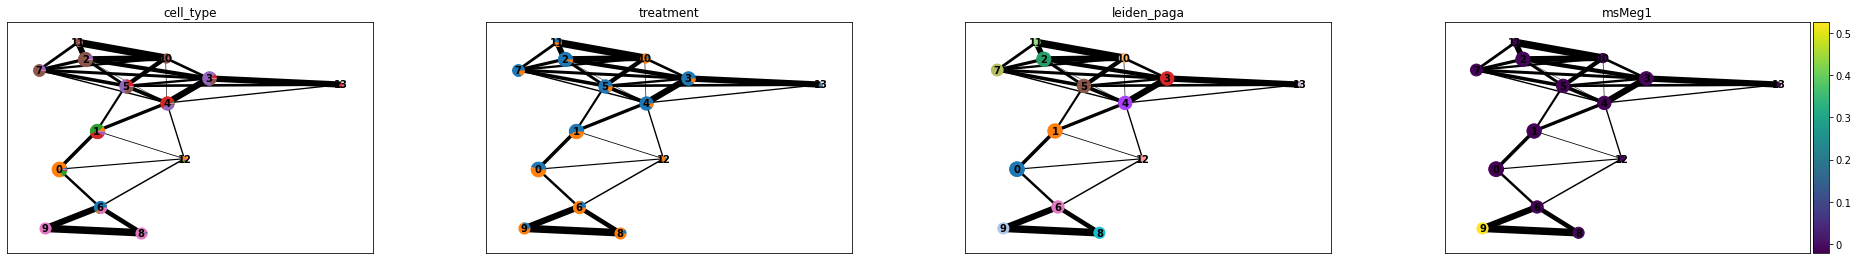

In [11]:
sc.tl.paga(adata, groups='leiden_paga')
sc.pl.paga(adata, color=['cell_type', 'treatment', 'leiden_paga', 'msMeg1'], threshold=0.05, show=False)

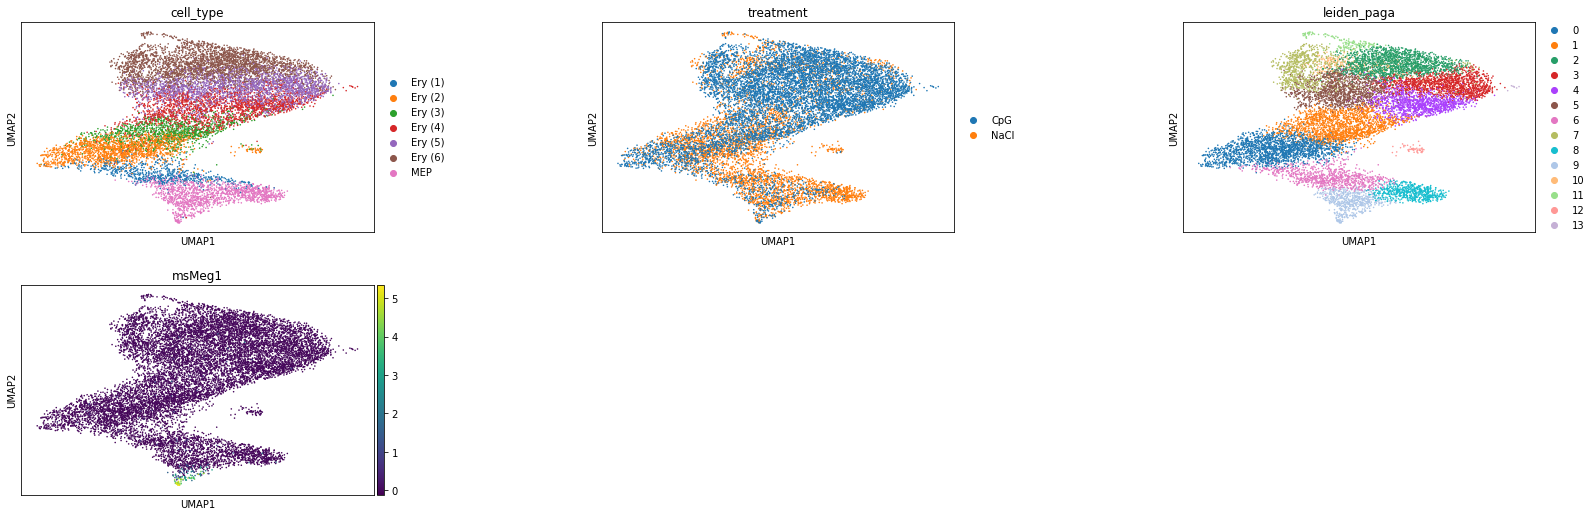

In [12]:
sc.tl.umap(adata, init_pos='paga')
sc.pl.umap(adata, color=['cell_type', 'treatment', 'leiden_paga', 'msMeg1'], wspace=0.5, ncols=3)

In [ ]:
sc.tl.draw_graph(adata, init_pos='paga')
sc.pl.draw_graph(adata, color=['cell_type', 'treatment', 'msMeg1'])

### Save result

In [ ]:
# pd.DataFrame(adata.obsm['X_umap'], index=adata.obs.index.to_series()).to_csv('data/object/adata_sct_hvg2000/reductions/X_umap_paga/reduction.csv')
# pd.DataFrame(adata.obs, index=adata.obs.index.to_series()).to_csv('data/object/adata_sct_hvg2000/meta/meta.csv')